In [20]:
import xarray as xr
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point
import rasterio
from rasterio.features import geometry_mask
import rioxarray
import cartopy.crs as ccrs


### Read EFAS regional lat/lon

In [21]:
# SORT OF USER CONFIGURATION
EFASDIR_HIST="/home/zappa/work_big/EFAS"

# Name Pattern of EFAS data, * reflects different years
fname_pat=f"{EFASDIR_HIST}/output/day/efas_panaro_*.nc"
#fname_pat=f"{EFASDIR_HIST}/output/6h/efas_italy_2020.nc"
ds = xr.open_mfdataset(fname_pat, combine='by_coords')

# starting and last year to be analysed
sy=1992
ly=2023



### Read watershed shape files

In [22]:
hape_dir="/work_big/users/zappa/TRANSLATE/HydroBasins/hybas_lake_eu_lev01-12_v1c/"
level="07"
shape_dir="/work_big/users/zappa/TRANSLATE/HydroBasins/hybas_lake_eu_lev01-12_v1c/"
shapef_path = os.path.join(shape_dir,f"hybas_lake_eu_lev{level}_v1c.shp")
shape_gdf = gpd.read_file(shapef_path)

### Select watershed of interest

In [23]:
# grid point of river point to be anlaysed (here Panaro near Modena)
tlat=44.65
tlon=10.99
point = Point(tlon, tlat)

contains_point = shape_gdf['geometry'].contains(point)

# extract entry of shapefile that contains the point
shape_basin_gdf = shape_gdf[contains_point]


In [24]:
# Assuming 'ds' is your xarray Dataset and 'gdf' is your GeoDataFrame
basin_geometry = shape_basin_gdf['geometry'].values

# Assuming 'ds' is your xarray Dataset and 'shape_basin_gdf' is your GeoDataFrame
ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds.rio.write_crs("epsg:4326", inplace=True)

# Create a mask where True values represent points outside the shapefile
mask = geometry_mask([geom for geom in basin_geometry ],
                     out_shape=(ds.sizes['lat'], ds.sizes['lon']),
                     transform=ds.rio.transform(),
                     invert=True)


# Apply the mask to the dataset
#print(mask.shape)
#print(ds['dis06'].shape)
ds_masked = ds['dis06'].where(mask)



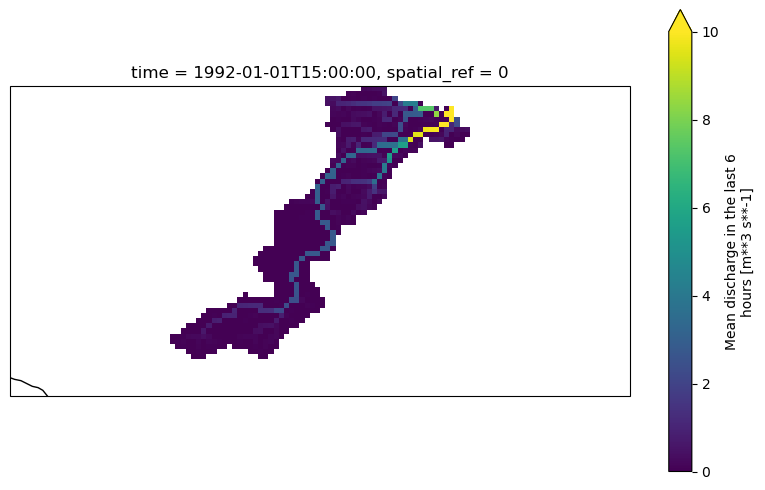

In [25]:
var=ds_masked.isel(time=0)

# Create a figure and axes with a geographic projection
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable
var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=10)
plt.xlim(10, 12)
plt.ylim(44, 45)

# Add coastlines
ax.coastlines()

# Show the plot
plt.show()

In [26]:
#identify grid points where_ds_masked is above 100 and set them to 0
ds_masked=ds_masked.where(ds_masked<100,0)

# set grid points where 

In [28]:
# identify grid
ds_masked.to_netcdf("test.nc")